# How would ReproNim do that?

## Volume 4: Manage local FreeSurfer results

This is the companion Jupyter notebook to *How would ReproNim do that Volume 4*.

To do: runtimes, DOI, link; abbreviated intro, skip installation

### Problem statement

I have performed a FreeSurfer analysis locally. I hear that ReproNim has some cool tools to manage the results of such an analysis. What are they and how do I do it?

In this example I’ve run FreeSurfer 6.0 on a set of 17 ABIDE subjects. The FreeSurfer $SUBJECTS_DIR is subjects/ and is stripped down to contain only stats/aseg.stats, stats/lh.aparc.stats, stats/rh.aparc.stats, and scripts/build-stamp.txt for each subject.

### In theory

Given the FreeSurfer results, we will use segstats_jsonld to create a NeuroImaging Data Model (NIDM) semantically marked up version of the volumetric data files. The semantic markup makes the FreeSurfer results self describing in that each result is associated with a concept that completely describes the result (type of measure (e.g. volume), structure (e.g. caudate nucleus), etc.). Complete semantic description of results makes integration of results from disparate sources easier. Once we’ve created the NIDM version of the FreeSurfer results, we can query our results using PyNIDM, and, more importantly, we can merge local results with publically available results and query across these combined data representations.

# EOF

Run asegstats2nidm on a single subject (MTM001) in order to express my FreeSurfer results in NIDM.

This takes the aseg.stats file for my particular subject (MTM001) and generates the following files:

Examine a NIDM file to see what it has using ‘PyNIDM query’. PyNIDM is installed with segstats_jsonld, but, if you need to reinstall it, see this link.

You can view this result file with:

So, that was one subject, but I have a whole FreeSurfer Subjects_dir set of (N=24) results, let’s make a NIDM representation of this complete set. It is an exercise to the reader to figure out how to accomplish this. On my MAC, I did something like the following:

This results in in a folder (MT) with subfolders for each subject (MTM001, etc.) which each contain the corresponding aseg_nidm.ttl, lh.aparc_nidm.ttl, and rh.aparc_nidm.ttl files.

It is unwieldy to work with 24 separate sets of files, so we can combine the relevant .ttl files into one, for our specific purposes. For the examples to follow, we will only need the ‘aseg’ results, so we will concatenate the ‘aseg’ NIDM files from each of the subjects into one file:

Querying on this combined file. 
We can now query this combined file for various content (remember that all this file has is the regional volumes per subject). First, let’s just look at the whole file for brain volumes (-bv):

You can ‘more’ this results file:

Next, we can ask for a specific brain structure (i.e. Hippocampus) by providing the appropriate SPARQL query: 

Great. So this is my local NIDM ‘pool’ of FreeSurfer data from a particular study. This would be more useful if I can include my demographics and other clinical/behavioral variables.

Adding My demographics.
For this example, I have my demographics (age (in years), sex, group) in a .csv file (MT_demog.csv). I want to express this data in the  NIDM file containing my freesurfer data (allMTseg.ttl) so that it can be queried and used for analysis.  I have two options, I can use csv2nidm and choose to add the demographics data to an existing NIDM file (shown below) or I can run csv2nidm without adding to an existing NIDM file and use `pynidm merge -s` later to merge NIDM files by subject ID.

At this point you have two separate NIDM files, one with demographics data and one with freesurfer data.  Let’s merge both together by the subject identifiers.  Now MTdemog_aseg.ttl has both your demographics data and freesurfer brain volumes

Querying for age and Hippocampus volume.
Now that we’ve merged our demographics data with our existing Freesurfer NIDM file we can now query this combined file with a query that will return the hippocampus volumes and include the subject age:
First we need to query for the project identifier in the NIDM file

Next let’s find out what we have available for Hippocampus statistics

Ok so of the results above I’m interested in left hippocampus volume which has id “fs_003343” and right hippocampus volume which has id “fs_003448”. Next let’s see if we have “age” in the dataset

Ok, looks like we have a variable for age.  Now let’s query the NIDM file and ask  for only these 3 fields of interest (notice the ?fields= part of the query) and save them to an output file for data analysis

Plot this result:

Adding public data. 
So since I can name multiple NIDM files to be the target of my query, and can combine multiple of my own local studies, or access other publically available sources of data. Let's grab the publically accessible version of the FreeSurfer analysis of the ADHD-200 data set:

Query your data and ABIDE data.  For this you can either do an integrated query writing a SPARQL query or you can do it in 2 steps using the pynidm query functions.  Using our previous method in step (7) and applying it to the set of files using some simple bash scripting:

Ok, so let’s unpack the command above.  First we’re looping through each of our NIDM files and running a pynidm query to get the project IDs from both (step 9(a) above).  Then we’re using these project IDs and running our pynidm query for the fields we’re interested in (step 9(d) above).  We’re writing these to two separate CSV files and then merging them using the tail command to convert the long format of the query outputs to a wide format for visualization with excel.  The remainder is simply cleaning up our temporary files.

Voila! Your data and public data together.

In [39]:
mkdir single_subject

In [40]:
segstats2nidm -add_de -s `pwd`/subjects/Olin_0050107 -o `pwd`/single_subject

Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...


In [41]:
ls single_subject

aseg_nidm.ttl		lh.aparc_nidm.ttl	rh.aparc_nidm.ttl


In [42]:
pynidm query -nl `pwd`/single_subject/aseg_nidm.ttl -bv -o `pwd`/single_query_results.txt

In [43]:
cat `pwd`/single_query_results.txt

,ID,tool,softwareLabel,federatedLabel,laterality,volume
0,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,CC_Posterior Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0015708,,1252.0
1,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Right-VentralDC Volume_mm3 (mm^3),,Right,4620.4
2,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Right hemisphere cerebral white matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0002437,Right,288733.501093
3,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Supratentorial volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0001869,,1268144.533251
4,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Volume of ventricles and choroid plexus (mm^3),,,16029.0
5,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,non-WM-hypointensities Volume_mm3 (mm^3),,,0.0
6,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,CC_Central Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002336,,942.4
7,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Mask Vo

60,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Left-Cerebellum-Cortex Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002129,Left,66116.8
61,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Left-VentralDC Volume_mm3 (mm^3),,Left,4864.8


In [44]:
mkdir all_subjects

In [45]:
for subject_dir in subjects/*
do
    subject=`basename $subject_dir`
    echo $subject
    mkdir all_subjects/$subject
    segstats2nidm -add_de -s `pwd`/$subject_dir -o `pwd`/all_subjects/$subject
    echo
done
echo done

CMU_0050646
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...

Caltech_51478
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...

KKI_0050778
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...

Leuven_0050691
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...

MaxMun_51348
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...

NYU_0050965
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...

OHSU_0050142
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...
Creating NIDM file...
Writing NIDM file...


In [46]:
aseg_list=`echo all_subjects/*/aseg_nidm.ttl | tr ' ' ,`

In [47]:
pynidm concat -nl $aseg_list -o all_subjects/all_aseg.ttl

In [49]:
pynidm query -nl all_subjects/all_aseg.ttl -bv -o all_query_results.txt

In [50]:
cat all_query_results.txt

,ID,tool,softwareLabel,federatedLabel,laterality,volume
0,OHSU_0050142,https://surfer.nmr.mgh.harvard.edu/,Left-choroid-plexus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001886,Left,506.9
1,SBL_51556,https://surfer.nmr.mgh.harvard.edu/,Left-choroid-plexus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001886,Left,271.8
2,UCLA_0051210,https://surfer.nmr.mgh.harvard.edu/,Left-choroid-plexus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001886,Left,461.6
3,SDSU_0050185,https://surfer.nmr.mgh.harvard.edu/,Left-choroid-plexus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001886,Left,396.9
4,Yale_0050559,https://surfer.nmr.mgh.harvard.edu/,Left-choroid-plexus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001886,Left,375.1
5,MaxMun_51348,https://surfer.nmr.mgh.harvard.edu/,Left-choroid-plexus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001886,Left,594.6
6,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Left-choroid-plexus 

57,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Subcortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000955,,69658.0
58,UM_0050404,https://surfer.nmr.mgh.harvard.edu/,Subcortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000955,,39399.0
59,Pitt_50014,https://surfer.nmr.mgh.harvard.edu/,Subcortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000955,,61933.0
60,Stanford_0051168,https://surfer.nmr.mgh.harvard.edu/,Subcortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000955,,67007.0
61,USM_50470,https://surfer.nmr.mgh.harvard.edu/,Subcortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000955,,60398.0
62,Caltech_51478,https://surfer.nmr.mgh.harvard.edu/,Subcortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000955,,64940.0
63,NYU_0050965,https://surfer.nmr.mgh.harvard.edu/,Subcortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_00009

121,UCLA_0051210,https://surfer.nmr.mgh.harvard.edu/,Right-WM-hypointensities Volume_mm3 (mm^3),,Right,0.0
122,SDSU_0050185,https://surfer.nmr.mgh.harvard.edu/,Right-WM-hypointensities Volume_mm3 (mm^3),,Right,0.0
123,Yale_0050559,https://surfer.nmr.mgh.harvard.edu/,Right-WM-hypointensities Volume_mm3 (mm^3),,Right,0.0
124,MaxMun_51348,https://surfer.nmr.mgh.harvard.edu/,Right-WM-hypointensities Volume_mm3 (mm^3),,Right,0.0
125,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Right-WM-hypointensities Volume_mm3 (mm^3),,Right,0.0
126,UM_0050404,https://surfer.nmr.mgh.harvard.edu/,Right-WM-hypointensities Volume_mm3 (mm^3),,Right,0.0
127,Pitt_50014,https://surfer.nmr.mgh.harvard.edu/,Right-WM-hypointensities Volume_mm3 (mm^3),,Right,0.0
128,Stanford_0051168,https://surfer.nmr.mgh.harvard.edu/,Right-WM-hypointensities Volume_mm3 (mm^3),,Right,0.0
129,USM_50470,https://surfer.nmr.mgh.harvard.edu/,Right-WM-hypointensities Volume_mm3 (mm^3),,Right,0.0
130,Caltech_51478,https://surfer.nmr.mgh

198,Caltech_51478,https://surfer.nmr.mgh.harvard.edu/,Left-WM-hypointensities Volume_mm3 (mm^3),,Left,0.0
199,NYU_0050965,https://surfer.nmr.mgh.harvard.edu/,Left-WM-hypointensities Volume_mm3 (mm^3),,Left,0.0
200,Trinity_0050240,https://surfer.nmr.mgh.harvard.edu/,Left-WM-hypointensities Volume_mm3 (mm^3),,Left,0.0
201,CMU_0050646,https://surfer.nmr.mgh.harvard.edu/,Left-WM-hypointensities Volume_mm3 (mm^3),,Left,0.0
202,KKI_0050778,https://surfer.nmr.mgh.harvard.edu/,Left-WM-hypointensities Volume_mm3 (mm^3),,Left,0.0
203,Leuven_0050691,https://surfer.nmr.mgh.harvard.edu/,Left-WM-hypointensities Volume_mm3 (mm^3),,Left,0.0
204,OHSU_0050142,https://surfer.nmr.mgh.harvard.edu/,Right-Thalamus-Proper Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001897,Right,7783.0
205,SBL_51556,https://surfer.nmr.mgh.harvard.edu/,Right-Thalamus-Proper Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001897,Right,8063.7
206,UCLA_0051210,https://surfer.nmr.mgh.harvard.edu/,Right-Thalamu

253,KKI_0050778,https://surfer.nmr.mgh.harvard.edu/,Left hemisphere cortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000956,Left,276875.195453
254,Leuven_0050691,https://surfer.nmr.mgh.harvard.edu/,Left hemisphere cortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000956,Left,287160.600606
255,OHSU_0050142,https://surfer.nmr.mgh.harvard.edu/,Brain-Stem Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002298,,20961.3
256,SBL_51556,https://surfer.nmr.mgh.harvard.edu/,Brain-Stem Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002298,,20357.4
257,UCLA_0051210,https://surfer.nmr.mgh.harvard.edu/,Brain-Stem Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002298,,17980.0
258,SDSU_0050185,https://surfer.nmr.mgh.harvard.edu/,Brain-Stem Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002298,,19107.1
259,Yale_0050559,https://surfer.nmr.mgh.harvard.edu/,Brain-Stem Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBE

320,CMU_0050646,https://surfer.nmr.mgh.harvard.edu/,Left-VentralDC Volume_mm3 (mm^3),,Left,5321.9
321,KKI_0050778,https://surfer.nmr.mgh.harvard.edu/,Left-VentralDC Volume_mm3 (mm^3),,Left,3499.3
322,Leuven_0050691,https://surfer.nmr.mgh.harvard.edu/,Left-VentralDC Volume_mm3 (mm^3),,Left,4255.2
323,OHSU_0050142,https://surfer.nmr.mgh.harvard.edu/,Left-Cerebellum-White-Matter Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002317,Left,13797.2
324,SBL_51556,https://surfer.nmr.mgh.harvard.edu/,Left-Cerebellum-White-Matter Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002317,Left,13196.2
325,UCLA_0051210,https://surfer.nmr.mgh.harvard.edu/,Left-Cerebellum-White-Matter Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002317,Left,12601.0
326,SDSU_0050185,https://surfer.nmr.mgh.harvard.edu/,Left-Cerebellum-White-Matter Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002317,Left,15741.6
327,Yale_0050559,https://surfer.nmr.mgh.harvard.edu/,Left-Cerebellum-W

382,Pitt_50014,https://surfer.nmr.mgh.harvard.edu/,Supratentorial volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0001869,,1055530.093907
383,Stanford_0051168,https://surfer.nmr.mgh.harvard.edu/,Supratentorial volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0001869,,1147749.402709
384,USM_50470,https://surfer.nmr.mgh.harvard.edu/,Supratentorial volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0001869,,1183999.697525
385,Caltech_51478,https://surfer.nmr.mgh.harvard.edu/,Supratentorial volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0001869,,1158384.558294
386,NYU_0050965,https://surfer.nmr.mgh.harvard.edu/,Supratentorial volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0001869,,1161840.51177
387,Trinity_0050240,https://surfer.nmr.mgh.harvard.edu/,Supratentorial volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0001869,,1099986.126593
388,CMU_0050646,https://surfer.nmr.mgh.harvard.edu/,Supratentorial volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0001869,,1197695

437,NYU_0050965,https://surfer.nmr.mgh.harvard.edu/,Estimated Total Intracranial Volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0013411,,1603712.32746
438,Trinity_0050240,https://surfer.nmr.mgh.harvard.edu/,Estimated Total Intracranial Volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0013411,,1566536.678052
439,CMU_0050646,https://surfer.nmr.mgh.harvard.edu/,Estimated Total Intracranial Volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0013411,,1697699.331476
440,KKI_0050778,https://surfer.nmr.mgh.harvard.edu/,Estimated Total Intracranial Volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0013411,,1285923.08102
441,Leuven_0050691,https://surfer.nmr.mgh.harvard.edu/,Estimated Total Intracranial Volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0013411,,1463350.730301
442,OHSU_0050142,https://surfer.nmr.mgh.harvard.edu/,Right-Hippocampus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001954,Right,4116.4
443,SBL_51556,https://surfer.nmr.mgh.harvard.edu/,Right-Hippoc

495,UCLA_0051210,https://surfer.nmr.mgh.harvard.edu/,Right-choroid-plexus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001886,Right,391.1
496,SDSU_0050185,https://surfer.nmr.mgh.harvard.edu/,Right-choroid-plexus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001886,Right,582.2
497,Yale_0050559,https://surfer.nmr.mgh.harvard.edu/,Right-choroid-plexus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001886,Right,361.8
498,MaxMun_51348,https://surfer.nmr.mgh.harvard.edu/,Right-choroid-plexus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001886,Right,406.8
499,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Right-choroid-plexus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001886,Right,695.3
500,UM_0050404,https://surfer.nmr.mgh.harvard.edu/,Right-choroid-plexus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001886,Right,251.0
501,Pitt_50014,https://surfer.nmr.mgh.harvard.edu/,Right-choroid-plexus Volume_mm3 (mm^3),http://purl.

549,MaxMun_51348,https://surfer.nmr.mgh.harvard.edu/,WM-hypointensities Volume_mm3 (mm^3),,,569.4
550,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,WM-hypointensities Volume_mm3 (mm^3),,,861.5
551,UM_0050404,https://surfer.nmr.mgh.harvard.edu/,WM-hypointensities Volume_mm3 (mm^3),,,2057.1
552,Pitt_50014,https://surfer.nmr.mgh.harvard.edu/,WM-hypointensities Volume_mm3 (mm^3),,,1172.5
553,Stanford_0051168,https://surfer.nmr.mgh.harvard.edu/,WM-hypointensities Volume_mm3 (mm^3),,,2452.9
554,USM_50470,https://surfer.nmr.mgh.harvard.edu/,WM-hypointensities Volume_mm3 (mm^3),,,1831.5
555,Caltech_51478,https://surfer.nmr.mgh.harvard.edu/,WM-hypointensities Volume_mm3 (mm^3),,,2316.7
556,NYU_0050965,https://surfer.nmr.mgh.harvard.edu/,WM-hypointensities Volume_mm3 (mm^3),,,1031.3
557,Trinity_0050240,https://surfer.nmr.mgh.harvard.edu/,WM-hypointensities Volume_mm3 (mm^3),,,762.1
558,CMU_0050646,https://surfer.nmr.mgh.harvard.edu/,WM-hypointensities Volume_mm3 (mm^3),,,1078.7
559,KKI_005077

612,OHSU_0050142,https://surfer.nmr.mgh.harvard.edu/,Left-Thalamus-Proper Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001897,Left,7909.2
613,SBL_51556,https://surfer.nmr.mgh.harvard.edu/,Left-Thalamus-Proper Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001897,Left,8504.7
614,UCLA_0051210,https://surfer.nmr.mgh.harvard.edu/,Left-Thalamus-Proper Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001897,Left,7173.8
615,SDSU_0050185,https://surfer.nmr.mgh.harvard.edu/,Left-Thalamus-Proper Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001897,Left,7935.0
616,Yale_0050559,https://surfer.nmr.mgh.harvard.edu/,Left-Thalamus-Proper Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001897,Left,7590.3
617,MaxMun_51348,https://surfer.nmr.mgh.harvard.edu/,Left-Thalamus-Proper Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001897,Left,8138.9
618,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Left-Thalamus-Proper Volume_mm3 (mm^3),http://purl

667,Yale_0050559,https://surfer.nmr.mgh.harvard.edu/,Left-Amygdala Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001876,Left,1816.8
668,MaxMun_51348,https://surfer.nmr.mgh.harvard.edu/,Left-Amygdala Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001876,Left,1532.1
669,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Left-Amygdala Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001876,Left,1816.8
670,UM_0050404,https://surfer.nmr.mgh.harvard.edu/,Left-Amygdala Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001876,Left,877.5
671,Pitt_50014,https://surfer.nmr.mgh.harvard.edu/,Left-Amygdala Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001876,Left,1652.5
672,Stanford_0051168,https://surfer.nmr.mgh.harvard.edu/,Left-Amygdala Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001876,Left,1873.5
673,USM_50470,https://surfer.nmr.mgh.harvard.edu/,Left-Amygdala Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001876,Left,1787.2
674

724,USM_50470,https://surfer.nmr.mgh.harvard.edu/,Brain Segmentation Volume Without Ventricles (mm^3),http://purl.obolibrary.org/obo/UBERON_0000955,,1316330.0
725,Caltech_51478,https://surfer.nmr.mgh.harvard.edu/,Brain Segmentation Volume Without Ventricles (mm^3),http://purl.obolibrary.org/obo/UBERON_0000955,,1320075.0
726,NYU_0050965,https://surfer.nmr.mgh.harvard.edu/,Brain Segmentation Volume Without Ventricles (mm^3),http://purl.obolibrary.org/obo/UBERON_0000955,,1298215.0
727,Trinity_0050240,https://surfer.nmr.mgh.harvard.edu/,Brain Segmentation Volume Without Ventricles (mm^3),http://purl.obolibrary.org/obo/UBERON_0000955,,1233295.0
728,CMU_0050646,https://surfer.nmr.mgh.harvard.edu/,Brain Segmentation Volume Without Ventricles (mm^3),http://purl.obolibrary.org/obo/UBERON_0000955,,1368198.0
729,KKI_0050778,https://surfer.nmr.mgh.harvard.edu/,Brain Segmentation Volume Without Ventricles (mm^3),http://purl.obolibrary.org/obo/UBERON_0000955,,1122759.0
730,Leuven_0050691,https://sur

789,UM_0050404,https://surfer.nmr.mgh.harvard.edu/,Right hemisphere cortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000956,Right,196074.531158
790,Pitt_50014,https://surfer.nmr.mgh.harvard.edu/,Right hemisphere cortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000956,Right,276443.984571
791,Stanford_0051168,https://surfer.nmr.mgh.harvard.edu/,Right hemisphere cortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000956,Right,280182.613751
792,USM_50470,https://surfer.nmr.mgh.harvard.edu/,Right hemisphere cortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000956,Right,318299.364227
793,Caltech_51478,https://surfer.nmr.mgh.harvard.edu/,Right hemisphere cortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000956,Right,299545.164641
794,NYU_0050965,https://surfer.nmr.mgh.harvard.edu/,Right hemisphere cortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_00009

845,NYU_0050965,https://surfer.nmr.mgh.harvard.edu/,Right-Cerebellum-Cortex Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002129,Right,61998.6
846,Trinity_0050240,https://surfer.nmr.mgh.harvard.edu/,Right-Cerebellum-Cortex Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002129,Right,58697.1
847,CMU_0050646,https://surfer.nmr.mgh.harvard.edu/,Right-Cerebellum-Cortex Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002129,Right,75891.9
848,KKI_0050778,https://surfer.nmr.mgh.harvard.edu/,Right-Cerebellum-Cortex Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002129,Right,56634.9
849,Leuven_0050691,https://surfer.nmr.mgh.harvard.edu/,Right-Cerebellum-Cortex Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002129,Right,56050.4
850,OHSU_0050142,https://surfer.nmr.mgh.harvard.edu/,Right-Cerebellum-White-Matter Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0002317,Right,13024.2
851,SBL_51556,https://surfer.nmr.mgh.harvard.edu/,Right-Cerebe

901,OHSU_0050142,https://surfer.nmr.mgh.harvard.edu/,Right-Putamen Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001874,Right,5621.6
902,SBL_51556,https://surfer.nmr.mgh.harvard.edu/,Right-Putamen Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001874,Right,5275.4
903,UCLA_0051210,https://surfer.nmr.mgh.harvard.edu/,Right-Putamen Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001874,Right,4856.9
904,SDSU_0050185,https://surfer.nmr.mgh.harvard.edu/,Right-Putamen Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001874,Right,5323.2
905,Yale_0050559,https://surfer.nmr.mgh.harvard.edu/,Right-Putamen Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001874,Right,6307.3
906,MaxMun_51348,https://surfer.nmr.mgh.harvard.edu/,Right-Putamen Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001874,Right,5623.1
907,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Right-Putamen Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001874,Right,67

959,UM_0050404,https://surfer.nmr.mgh.harvard.edu/,Left-Inf-Lat-Vent Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0006091,Left,68.3
960,Pitt_50014,https://surfer.nmr.mgh.harvard.edu/,Left-Inf-Lat-Vent Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0006091,Left,503.3
961,Stanford_0051168,https://surfer.nmr.mgh.harvard.edu/,Left-Inf-Lat-Vent Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0006091,Left,209.4
962,USM_50470,https://surfer.nmr.mgh.harvard.edu/,Left-Inf-Lat-Vent Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0006091,Left,197.0
963,Caltech_51478,https://surfer.nmr.mgh.harvard.edu/,Left-Inf-Lat-Vent Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0006091,Left,345.6
964,NYU_0050965,https://surfer.nmr.mgh.harvard.edu/,Left-Inf-Lat-Vent Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0006091,Left,221.3
965,Trinity_0050240,https://surfer.nmr.mgh.harvard.edu/,Left-Inf-Lat-Vent Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERO

1017,CMU_0050646,https://surfer.nmr.mgh.harvard.edu/,Total cortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000956,,580465.112196
1018,KKI_0050778,https://surfer.nmr.mgh.harvard.edu/,Total cortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000956,,563574.07313
1019,Leuven_0050691,https://surfer.nmr.mgh.harvard.edu/,Total cortical gray matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0000956,,582187.808643
1020,OHSU_0050142,https://surfer.nmr.mgh.harvard.edu/,Total cerebral white matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0002437,,491065.158174
1021,SBL_51556,https://surfer.nmr.mgh.harvard.edu/,Total cerebral white matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0002437,,540509.219536
1022,UCLA_0051210,https://surfer.nmr.mgh.harvard.edu/,Total cerebral white matter volume (mm^3),http://purl.obolibrary.org/obo/UBERON_0002437,,465824.579084
1023,SDSU_0050185,https://surfer.nmr.mgh.harvard.edu/,Total cereb

In [51]:
pynidm query -nl all_subjects/all_aseg.ttl -q hippocampus_query.sparql -o all_hippocampus_results.txt


real	0m8.018s
user	0m7.894s
sys	0m0.263s


In [52]:
cat all_hippocampus_results.txt

,ID,tool,softwareLabel,federatedLabel,laterality,volume
0,OHSU_0050142,https://surfer.nmr.mgh.harvard.edu/,Left-Hippocampus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001954,Left,4272.2
1,SBL_51556,https://surfer.nmr.mgh.harvard.edu/,Left-Hippocampus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001954,Left,4050.6
2,UCLA_0051210,https://surfer.nmr.mgh.harvard.edu/,Left-Hippocampus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001954,Left,3781.3
3,SDSU_0050185,https://surfer.nmr.mgh.harvard.edu/,Left-Hippocampus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001954,Left,5014.5
4,Yale_0050559,https://surfer.nmr.mgh.harvard.edu/,Left-Hippocampus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001954,Left,4145.3
5,MaxMun_51348,https://surfer.nmr.mgh.harvard.edu/,Left-Hippocampus Volume_mm3 (mm^3),http://purl.obolibrary.org/obo/UBERON_0001954,Left,4089.1
6,Olin_0050107,https://surfer.nmr.mgh.harvard.edu/,Left-Hippocampus Volume_mm3 (mm^

`csv2nidm -csv demographics.csv -out demographics.ttl` run earlier; also need INTERLEX_API_KEY

In [53]:
pynidm merge -nl demographics.ttl,all_subjects/all_aseg.ttl -s -o demog_aseg.ttl


real	0m14.595s
user	0m14.349s
sys	0m0.328s


In [54]:
pynidm query -nl demog_aseg.ttl -u /projects

UUID
------------------------------------
a3814f98-8993-11ea-9534-f01898563600

real	0m5.554s
user	0m5.464s
sys	0m0.267s


In [55]:
pynidm query -nl demog_aseg.ttl -u /projects/a3814f98-8993-11ea-9534-f01898563600 | grep Hippo

fs_003342           Left-Hippocampus NVoxels
fs_003343           Left-Hippocampus Volume_mm3 (mm^3)
fs_003347           Left-Hippocampus normMax (MR)
fs_003344           Left-Hippocampus normMean (MR)
fs_003346           Left-Hippocampus normMin (MR)
fs_003348           Left-Hippocampus normRange (MR)
fs_003345           Left-Hippocampus normStdDev (MR)
fs_003447           Right-Hippocampus NVoxels
fs_003448           Right-Hippocampus Volume_mm3 (mm^3)
fs_003452           Right-Hippocampus normMax (MR)
fs_003449           Right-Hippocampus normMean (MR)
fs_003451           Right-Hippocampus normMin (MR)
fs_003453           Right-Hippocampus normRange (MR)
fs_003450           Right-Hippocampus normStdDev (MR)

real	0m2.523s
user	0m2.474s
sys	0m0.243s


In [56]:
pynidm query -nl demog_aseg.ttl -u /projects/a3814f98-8993-11ea-9534-f01898563600 | grep age

ImageContrastType                                []
ImageUsageType                                   []
age_2q73ou5         age

real	0m2.475s
user	0m2.431s
sys	0m0.246s


In [57]:
pynidm query -nl demog_aseg.ttl -u /projects/a3814f98-8993-11ea-9534-f01898563600?fields=age,fs_003343 -o age_hippo_raw.csv


real	0m5.617s
user	0m5.511s
sys	0m0.281s


In [58]:
cat age_hippo_raw.csv

,subject,field,datumType,label,value,units
0,c395b12c-8993-11ea-9534-f01898563600,fs_003343,ilx_0738276,Left-Hippocampus Volume_mm3 (mm^3),4722.7,mm^3
1,c395b12c-8993-11ea-9534-f01898563600,age,,,14,
2,c3a285dc-8993-11ea-9534-f01898563600,fs_003343,ilx_0738276,Left-Hippocampus Volume_mm3 (mm^3),3838.9,mm^3
3,c3a285dc-8993-11ea-9534-f01898563600,age,,,9,
4,a39786be-8993-11ea-9534-f01898563600,fs_003343,ilx_0738276,Left-Hippocampus Volume_mm3 (mm^3),4050.6,mm^3
5,a39786be-8993-11ea-9534-f01898563600,age,,,20,
6,a3994fc6-8993-11ea-9534-f01898563600,fs_003343,ilx_0738276,Left-Hippocampus Volume_mm3 (mm^3),5014.5,mm^3
7,a3994fc6-8993-11ea-9534-f01898563600,age,,,12,
8,a39eaf16-8993-11ea-9534-f01898563600,fs_003343,ilx_0738276,Left-Hippocampus Volume_mm3 (mm^3),3781.3,mm^3
9,a39eaf16-8993-11ea-9534-f01898563600,age,,,16,
10,d3a46f96-8993-11ea-9534-f01898563600,fs_003343,ilx_0738276,Left-Hippocampus Volume_mm3 (mm^3),4145.3,mm^3
11,d3a46f96-8993-11ea-9534-f01898563600,age,,,12,
12,a393ad32-89

In [59]:
tail -n +2 age_hippo_raw.csv  | paste -d , - - > age_hippo.csv

In [60]:
cat age_hippo.csv

0,c395b12c-8993-11ea-9534-f01898563600,fs_003343,ilx_0738276,Left-Hippocampus Volume_mm3 (mm^3),4722.7,mm^3,1,c395b12c-8993-11ea-9534-f01898563600,age,,,14,
2,c3a285dc-8993-11ea-9534-f01898563600,fs_003343,ilx_0738276,Left-Hippocampus Volume_mm3 (mm^3),3838.9,mm^3,3,c3a285dc-8993-11ea-9534-f01898563600,age,,,9,
4,a39786be-8993-11ea-9534-f01898563600,fs_003343,ilx_0738276,Left-Hippocampus Volume_mm3 (mm^3),4050.6,mm^3,5,a39786be-8993-11ea-9534-f01898563600,age,,,20,
6,a3994fc6-8993-11ea-9534-f01898563600,fs_003343,ilx_0738276,Left-Hippocampus Volume_mm3 (mm^3),5014.5,mm^3,7,a3994fc6-8993-11ea-9534-f01898563600,age,,,12,
8,a39eaf16-8993-11ea-9534-f01898563600,fs_003343,ilx_0738276,Left-Hippocampus Volume_mm3 (mm^3),3781.3,mm^3,9,a39eaf16-8993-11ea-9534-f01898563600,age,,,16,
10,d3a46f96-8993-11ea-9534-f01898563600,fs_003343,ilx_0738276,Left-Hippocampus Volume_mm3 (mm^3),4145.3,mm^3,11,d3a46f96-8993-11ea-9534-f01898563600,age,,,12,
12,a393ad32-8993-11ea-9534-f01898563600,fs_003343,ilx_073

In [61]:
cat plot

#!/usr/bin/env python3

import sys
import matplotlib.pyplot as plt
import pandas as pd

if len(sys.argv) == 3:
    local_file = sys.argv[1]
    adhd200_file = None
    out_file = sys.argv[2]
else:
    local_file = sys.argv[1]
    adhd200_file = sys.argv[2]
    out_file = sys.argv[3]

if not adhd200_file:
    data = pd.read_csv(local_file, header=None)
    plt.plot(data[12], data[5], 'k.')
else:
    data1 = pd.read_csv(local_file, header=None)
    plt.plot(data1[12], data1[5], 'b.', label='Local data')
    data2 = pd.read_csv('adhd200_age_hippo.csv', header=None)
    plt.plot(data2[12], data2[5], 'r.', label='ADHD-200 data')
    plt.legend()

plt.title('Hippocampus volume vs age')
plt.xlabel('Age (years)')
plt.ylabel('Volume (mm$^3$)')
plt.savefig(out_file)

sys.exit(0)

# eof


In [62]:
./plot age_hippo.csv vol_vs_age.png

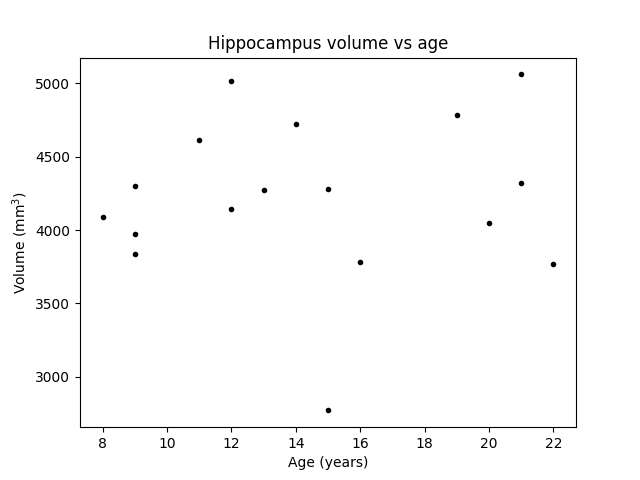

In [63]:
display < vol_vs_age.png

In [64]:
curl -o adhd200_brown.ttl https://raw.githubusercontent.com/dbkeator/simple2_NIDM_examples/master/datasets.datalad.org/adhd200/RawDataBIDS/Brown/nidm.ttl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  760k  100  760k    0     0  1357k      0 --:--:-- --:--:-- --:--:-- 1355k


In [66]:
pynidm query -nl adhd200_brown.ttl -u /projects

UUID
------------------------------------
aedd7d40-6181-11ea-ab38-003ee1ce9545

real	0m2.562s
user	0m2.480s
sys	0m0.255s


In [67]:
pynidm query -nl adhd200_brown.ttl -u /projects/aedd7d40-6181-11ea-ab38-003ee1ce9545?fields=age,fs_003343 -o adhd200_age_hippo_raw.csv


real	0m55.749s
user	0m54.774s
sys	0m0.478s


In [68]:
tail -n +2 adhd200_age_hippo_raw.csv  | paste -d , - - > adhd200_age_hippo.csv

In [69]:
./plot age_hippo.csv adhd200_age_hippo.csv all_vol_vs_age.png

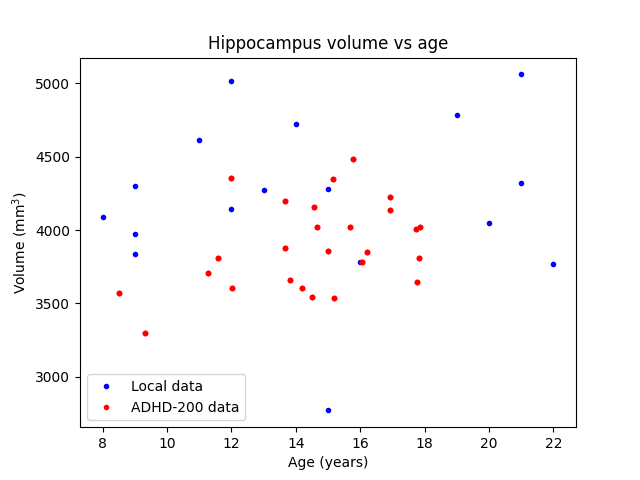

In [70]:
display < all_vol_vs_age.png